<a href="https://colab.research.google.com/github/asanneh/CS109A_2019_GR31_FINAL_PROJECT/blob/master/notebook/FinalProject31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries and Million Playlist Data

In [0]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random

Helpful guide to using Google Colab: https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c. 

The Million Playlist Data (MPD) in its raw format is made up of CSVs 0 through 999, each with 1000 playlists. Each CSV is 11 MB, so the unzipped size of the data is 11 GB. For processing in a reasonable time frame, code can be run on the GPU (TPU) by going to Runtime > change runtime type > GPU (TPU). That should give more space. 

To get access to the data, first the Google Drive holding the dataset must be mounted. The raw MPD was merged into a single CSV file called 'combined_playlist.csv'. This CSV file has an extra row denoting what CSV file the playlists came from. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')# force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#load entire playlist to dataframe, note there is a performance hit here since I/O can't be parallelized
#You can limit how many rows you read in by including nrows
#songs = pd.read_csv('/content/drive/My Drive/Spotify/combined_playlist_v2.csv') #nrows = 10000000
songs = pd.read_csv('/content/drive/My Drive/CS109A project/Spotify/combined_playlist_v2.csv')
print(f'dataset shape: {songs.shape}')

dataset shape: (66346428, 11)


In [3]:
print(f'unique CSV files: {len(songs.file_name.unique())}')
print(f'number of playlists: {songs.pidfile_name.nunique()}')
print(f'unique songs: {len(songs.track_uri.unique())}')
songs.head()

unique CSV files: 1000
number of playlists: 1000000
unique songs: 2262292


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name,pidfile_name
0,0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",songs284,0songs284
1,0,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,songs284,0songs284
2,0,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,songs284,0songs284
3,0,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,songs284,0songs284
4,0,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,songs284,0songs284


The columns of the MPD are as follows:

1.   **pid:** playlist ID within the original CSV
2.   **pos:** position of song within the playlist
3.   **artist_name:** name of the artist (string)
4.   **track_uri:** unique track Spotify Identifier
5.   **artist_uri:** unique artist Spotify Identifier
6.   **track_name:** name of the track (string)
7.   **album_uri:** unique album Spotify Identifier
8.   **duration_ms:** track duration in ms
9.   **album_name:** name of album
10.  **file_name:** identifier of CSV where playlists came from 
11.  **pidfile_name:** unique playlist identifier

In order to make recommendations for songs for a particular playlist, we will eventually need to create a matrix of playlists by all the unique songs in the MPD. For this, we will need to pick the appropriate song identifier to make sure we are capturing all the unique songs. We will compare **track_name** vs **track_uri** labels to see what is better. 



In [0]:
#what identifier should we use
print(f'unique songs by uri: {len(songs.track_uri.unique())}')
print(f'unique songs by name: {len(songs.track_name.unique())}\n')
#print(f'unique artist+track combos (uri):{len(songs.groupby(["track_uri", "artist_uri"]))}')
#print(f'unique artist+track combos (name):{len(songs.groupby(["track_name", "artist_name"]))}\n')


unique songs by uri: 2262292
unique songs by name: 1483760



We see here that the number of unique songs by **track_uri** is larger than what is given when using **track_name**. This fits well with our understanding that song names can repeated, but that Spotify has unique identifiers for the songs that can disambiguate songs of the same name. Let's take a look at several songs with the same name. 

In [0]:
#drop duplicated songs and count occurences of song names
songs.drop_duplicates(subset = 'track_uri')['track_name'].value_counts()

Intro                                                1559
Silent Night                                          946
Home                                                  843
White Christmas                                       617
O Holy Night                                          554
                                                     ... 
Burro Amarrado                                          1
Appalachian Spring (Original Version): Meno mosso       1
Messa da Requiem: 2. Lacrymosa                          1
The Painters Portrait, Pt. 1                            1
Show Me What You Got (feat. Trina)                      1
Name: track_name, Length: 1483759, dtype: int64

It seems that **track_uris** are a better way to go here - unique to each song and artist, regardless of name overlaps. Especially with cover songs - could be entirely different styles and belong in different playlists. 

# Data Wrangling

Google Colab cannot do EDA on the whole file without running out of RAM on the GPU. To try and ameliorate this and to allow us enough RAM to do model building as well, we are choosing to randomly drop 50% of the playlists from our original file, leaving us with 500K playlists to work with. While we would like to be able to work with the whole dataset, we do not have nearly enough compute power available to us to effectively analyze it. 

In [0]:
random.seed(0)
pid_to_keep = np.random.choice(songs['pidfile_name'].unique(), 500000, replace = False)
drop_idx = songs.loc[songs.pidfile_name.isin(pid_to_keep)].index

In [0]:
songs.drop(drop_idx, inplace = True)

In [10]:
print(f'number of playlists: {songs.pidfile_name.nunique()}')

number of playlists: 500000


In [11]:
#let's drop the unneeded columns pid and file_name and just keep pidfile_name
songs.drop(columns = ['pid', 'file_name'], inplace=True)
songs.shape

(33143261, 9)

In [0]:
songs.to_csv('500k_playlists.csv')

In [0]:
!cp 500k_playlists.csv /content/drive/My\ Drive/CS109A\ project/Spotify

# Data Cleaning

Before we proceed with further data analysis, we should make sure that our data is clean - no missingness, consistent types, etc. 

In [0]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random

In [2]:
songs = pd.read_csv('/content/drive/My Drive/CS109A project/Spotify/500k_playlists.csv', index_col=0)
print(f'dataset shape: {songs.shape}')
songs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


dataset shape: (33143261, 9)


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",0songs284
1,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,0songs284
2,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,0songs284
3,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,0songs284
4,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,0songs284


In [3]:
#are there any missing values?
songs.isnull().sum()

Unnamed: 0      0
pos             0
artist_name     8
track_uri       0
artist_uri      0
track_name      1
album_uri       0
duration_ms     0
album_name      4
pidfile_name    0
dtype: int64

In [4]:
#what are the data types?
songs.dtypes

Unnamed: 0       int64
pos              int64
artist_name     object
track_uri       object
artist_uri      object
track_name      object
album_uri       object
duration_ms      int64
album_name      object
pidfile_name    object
dtype: object

In [5]:
#we have some missing values in artist_name, album_name, and track_name
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.artist_name.isnull()]

,Unnamed: 0,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
2145279,4293081,4,NaN,spotify:track:4eUsRojrbcfPsdUD7qZZo7,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Brindisi Ver. 1,spotify:album:5iVF4oYu6lVTOQj2iu6b2b,194386,Opera Greatest Hits,591songs246
4403865,8820322,128,NaN,spotify:track:14sdk4mdW6KzKfa8tk0hnn,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Hello,spotify:album:2CnxsT3zuHV2rDSVqpKxde,18706,Anticon Label Sampler 1999 - 2004,885songs286
4403880,8820337,143,NaN,spotify:track:0zyLruNSGOBFsYvVKIrhHo,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Pity Party People Interlude,spotify:album:2CnxsT3zuHV2rDSVqpKxde,19413,Anticon Label Sampler 1999 - 2004,885songs286
16140533,32306209,103,NaN,spotify:track:1x4tbfq3ywvTvJVwgVsSHN,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Menace,spotify:album:63T4BKB9CwXzfMuUBE8RWX,232551,Cellar,63songs816
17312098,34634330,58,NaN,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,NaN,434songs744
27833252,55711352,80,NaN,spotify:track:0VffYn4XPllw50b5t8eyU9,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Love Changes Everything - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,186786,A Musical Affair (Track by Track),895songs107
27833253,55711353,81,NaN,spotify:track:6e7I9PmXBHHmNzoHILhY5e,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,The Music of the Night - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,211080,A Musical Affair (Track by Track),895songs107
30895014,61851152,45,NaN,spotify:track:0hxxhWW4v5dFTTzudq6BT8,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Flute Gasp,spotify:album:5Us2V8uDxjNnlAqpS5olMr,236191,Xtreme Tremble,141songs261


By referencing the **track_uri** in Spotify, it seems that 4 tracks in this category are classical music songs where the primary artist (writer) is listed as N/A. Two tracks are from the same indie rap album, where the primary artist is also N/A. In these cases, it seems that this is truly missing information. What is amusing is that the **artist_uri** for these songs actually points to a reggae group called 'N/A'. When you look at their discography, they have a vast number of classical and opera songs attributed to them...

Besides that, there is one artist called 'NA' and one artist called 'null'. 

It doesn't seem that this will interfere with our collaborative filtering recommender system, just maybe make the song credit information a little more confusing. We will not filter these songs out in the mean time, but we will change the **artist_uri** to NaN to reflect this information for the songs with missing info, and update **artist_name** for those artists named 'NA' and 'null'.   

In [0]:
songs.loc[songs.artist_uri == 'spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is', 'artist_name'] = ['NA']*2
songs.loc[songs.artist_uri == 'spotify:artist:3fmUow9gSgOouUw2UnUtzg', 'artist_name'] = ['null']
songs.loc[songs.artist_uri == 'spotify:artist:4oPYazJJ1o4rWBrTw9lm40', 'artist_uri'] = [np.nan]*5


In [8]:
#we have some missing values in artist_name and album_name. 
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.album_name.isnull()]

,Unnamed: 0,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
3528690,7069563,86,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,513songs494
3640153,7293324,20,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,868songs133
5907652,11813676,44,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,116songs122
17312098,34634330,58,null,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,NaN,434songs744


Loop Garou annoyingly named his album 'N/A' which got translated to a NaN in the pandas dataframe. Artist named 'null' also has a track and album named 'null' so that's great. Let's fix the labels. 

In [0]:
songs.loc[songs.album_uri == 'spotify:album:4zLXjNbJaNvj8X97GAnr5i', 'album_name'] = ['N/A']*3
songs.loc[songs.album_uri == 'spotify:album:0yiPGCcuMDakfqcmvY6Rk1', 'album_name'] = ['null']

In [11]:
#missing track names?
songs.loc[songs.track_name.isnull()]

,Unnamed: 0,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
17312098,34634330,58,null,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,null,434songs744


Once again, we have our null artist with null album and null song. We will fix that as well as the null song name for the other artist. 

In [0]:
songs.loc[songs.track_uri == 'spotify:track:3uxxOSDWiBqKBnbU2eSAxI', 'track_name'] = ['null']

# EDA - PLEASE ADD MORE STUFF HERE

count    500000.000000
mean         66.286522
std          53.645746
min           5.000000
25%          26.000000
50%          49.000000
75%          91.000000
max         250.000000
Name: track_uri, dtype: float64

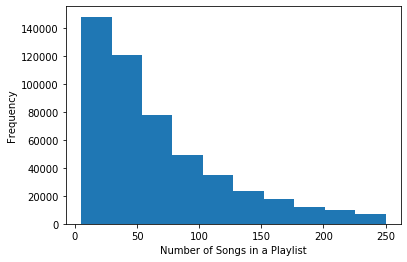

In [13]:
#what is the average length of a playlist - make sure to group by FILE NAME AND PID!!
ax = songs.groupby(['pidfile_name']).count()['track_uri'].plot(kind = 'hist');
ax.set_xlabel('Number of Songs in a Playlist')
songs.groupby(['pidfile_name']).count()['track_uri'].describe()

# Playlist x Unique Songs Sparse Matrix

For further model building, it will be helpful to have a sparse matrix that encodes our playlists in rows and our unique songs in columns. A 1 in a particular cell of the matrix means that playlist has that song. A 0 means it doesn't. We need to carefully look at sparsity here - a matrix that is too sparse means that using matrix factorization to learn latent variables wouldn't work very well because there aren't enough playlist/song interactions. 

references: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/, https://jessesw.com/Rec-System/

In [3]:
#make sparse binary matrix of playlist x uniq song? 0 if song not in playlist, 1 if it is

n_pls = songs.pidfile_name.unique().shape[0]
n_songs = songs.track_uri.unique().shape[0]

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {100 - float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.3f}%')


Num playlists: 500000
Num unique songs: 1607449
Sparsity: 99.996%


This is very high sparsity! It might be too low for us to make matrix factorization models work. We should try filtering out songs that appear less than N (N is our choice) times across the whole dataset and playlists with too few songs. This might serve to make our matrix more dense. We are aiming for a sparsity of 99.5% and below (https://jessesw.com/Rec-System/)

*N.B. The reason for dropping 'in place' is that the RAM on the Google Collab GPU is insufficient for multiple instances of the whole 11GB dataset. To keep the RAM in check, we can't have two instances of the full or nearly full data.* 

In [0]:
def threshold_data(songs, min_pid_length, min_track_cts):
  '''drops all playlists with length less than 20 tracks and all tracks featured 
  less than 10 times in the data. Does so iteratively until data size remains stable.
  Inspired by code from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/'''

  done = False
  while not done:
    starting_shape = songs.shape[0] #print starting num rows
    #filter playlists
    pid_cts = songs['pidfile_name'].value_counts()
    drop_idx = songs.loc[songs.pidfile_name.isin(pid_cts[pid_cts < min_pid_length].index)].index
    songs.drop(drop_idx, inplace = True)
    #filter songs
    track_cts = songs['track_uri'].value_counts()
    drop_idx = songs.loc[songs.track_uri.isin(track_cts[track_cts < min_track_cts].index)].index
    songs.drop(drop_idx, inplace = True)
    #print ending num rows
    ending_shape = songs.shape[0]
    #break out of while loop if no more rows filtered out
    if starting_shape == ending_shape:
      done = True

  n_pls = songs.pidfile_name.unique().shape[0]
  n_songs = songs.track_uri.unique().shape[0]

  #calculate new matrix sparsity
  print(f'Num playlists: {n_pls}')
  print(f'Num unique songs: {n_songs}')
  print(f'Sparsity: {100 - float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.5f}%')


In [10]:
threshold_data(songs, 50, 50)

Num playlists: 188756
Num unique songs: 48131
Sparsity: 99.79794%


In [0]:
songs.to_csv('dense_playlists.csv')

In [0]:
!cp dense_playlists.csv /content/drive/My\ Drive/CS109A\ project/Spotify

While 99.5% sparsity was the target range recommended by the author of https://jessesw.com/Rec-System/, we expressed hesitation in filtering out too much data to get a dense matrix. We were hesitant that our model would perform well on playlists with few songs, so we decided that a sparsity of 99.8% would be acceptable for further analysis. For reference, Ethan Rosenthal (https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/) used a sparsity of 99.86% with some degree of success. 

# Train-Test Split

We want to be able to assess the performance of our model, but it would be erroneous to drop whole playlists from the dataset, since our collaborative filtering models will eventually need the whole dataset (or as much of it as we retained) to learn the latent factors. Therefore, by recommendation of these two websites (https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/, https://jessesw.com/Rec-System/), we will instead use a training set where a certain number of playlist-song interactions are masked from us. 

To do this, we first want to make a sparse matrix that contains a 1 if the playlist has a particular song and a 0 if it doesn't. We will save the full sparse matrix as 'item_user_matrix' and that will be our test set. 

To make our train set, we will take the full sparse matrix and mask 10 random cells containg a '1' for each playlist. Since each playlist in our dataset has 50 songs, that should give us 20% of our data to use for testing performance. 

In [17]:
#songs = pd.read_csv('/content/drive/My Drive/CS109A project/Spotify/dense_playlists.csv', index_col=0)
print(f'min playlist length: {songs.pidfile_name.value_counts().min()}')
print(f'min track counts: {songs.track_uri.value_counts().min()}')
songs.reset_index(drop=True, inplace=True)

min playlist length: 50
min track counts: 50


In [0]:
#make sparse matrix
cols = songs.pidfile_name.astype('category').cat.codes # make category codes/indices for each playlist
rows = songs.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(songs.shape[0]) #1s if song is in playlist

In [19]:
likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs.groupby(by=['pidfile_name', 'track_uri']).count()['track_name'].shape)
likes

(18078662,)


<48131x188756 sparse matrix of type '<class 'numpy.float64'>'
	with 18078662 stored elements in Compressed Sparse Row format>

For later model fitting with the implicit library, we saved the dataset as a sparse row matrix with the items (tracks) as rows and users (playlists) as columns. We can see that we have ~18 million unique interactions between playlist and song. 

In [0]:
sparse.save_npz('item_user_matrix.npz', likes)

In [0]:
!cp item_user_matrix.npz /content/drive/My\ Drive/CS109A\ project/Spotify

In [28]:
#check that the min number of interactions for both songs and playlists is 50
print(f'min num songs in playlist: {likes.sum(axis=1).min()}')
print(f'min num playlists song is featured in: {likes.sum(axis=0).min()}')

min num songs in playlist: 50.0
min num playlists song is featured in: 50.0


In [0]:
def train_test_split(likes, num_to_mask):
  '''
  Make training set with masked interactions

  likes: the full sparse matrix of playlist-song interactions
  num_to_mask: how many interactions we will mask for our training set
  '''
  

# Popularity-based Model

I am using the two websites here to figure out how to make a recommender from a sparse matrix:
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://jessesw.com/Rec-System/


A very simple song recommender would recommend the top K (K is up to us) most popular songs in the MPD regardless of the playlist we want song recommendations for. Since we are dealing with implicit ratings (basically, the presence and absence of a song in a playlist), song popularity can be measured by how many unique playlists it is featured in. We don't want our metric to be skewed by someone who made a playlist with 600 copies of Missy Elliot's 'Work It' (though I highly respect their vibes.)

# Collaborative Filtering Model